In [22]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

sns.set()

In [23]:
class GraphLaplacian:
    def __init__(self, X0, Y0, X1):
        self.__X0 = X0
        self.__Y0 = Y0
        self.__X1 = X1
        self.__solved = False
        
    def plot_problem(self):
        colors = ["#ffffff", "#ff6361", "#003f5c"]
        X = np.array(self.__X0 + self.__X1)
        labeled_i = [i for i in range(len(self.__X0))]
        # Set your custom color palette
        sns.set_palette(sns.color_palette(colors))

        fig, ax = plt.subplots()

        ax.scatter([a[0] for a in X],[a[1] for a in X], label="unknown")
        ax.scatter([X[i][0] for i in labeled_i[:np.int32(L/2)]],[X[i][1] for i in labeled_i[:np.int32(L/2)]], label="0")
        ax.scatter([X[i][0] for i in labeled_i[np.int32(L/2):]],[X[i][1] for i in labeled_i[np.int32(L/2):]], label="1")

        ax.legend()
        plt.title("Problem")
        plt.show()
        
    def create_linear_system(self):
        ## VARIABLE HELPER
        X = np.array(self.__X0 + self.__X1)
        self.__X = X
        labeled_i = [i for i in range(len(self.__X0))]
        self.__labeled_i = labeled_i
        sigma = 1
        yl_temp = dict(zip(labeled_i, self.__Y0))
        self.__yl_temp = yl_temp
        xl = np.array([x for i,x in enumerate(X) if i in labeled_i])
        xu = np.array([x for i,x in enumerate(X) if not(i in labeled_i)])

        ## Create Matrix W
        def weight_func(xi, xj, sigm):
            xixj = xi - xj
            xixj2 = np.dot(xixj, xixj)
            return np.float16(np.exp(-(xixj2)/(sigm**2)))

        W = []
        for i,x in enumerate(X):
            w = [weight_func(X[i], X[j], sigma) for j in range(len(X))]
            W.append(w)
        W = np.array(W)

        ## Matrix A' (ΔU)
        A_ = []
        for i,x in enumerate(X):
            a = [W[i][j] if i!=j else -np.sum(W[i]) for j in range(len(X))]
            A_.append(a)
        A_ = np.array(A_)

        ## Matrix A
        A = []
        for i,x in enumerate(X):
            if i in labeled_i:
                a = [1 if j==i else 0 for j in range(len(X))]
            else:
                a = [x for x in A_[i]]
            A.append(a)
        A = np.array(A)

        ## Create b
        b = np.array([0 if i not in labeled_i else yl_temp[i] for i,x in enumerate(X)]).T
        
        return A, b
    
    def __gs_method(self, A, b ,x=None, max_i=1000, error=1e-9):
        n = len(b)
        if not x:
            x = np.ones(n)
        r0 = np.dot(x,x)
        for it in range(max_i):
            for i in range(n):
                sig = 0
                for j in range(n):
                    if j != i:
                        sig += A[i][j]*x[j]
                x[i] = (1/A[i][i])*(b[i] - sig)
            r1 = np.dot(x,x)
            err = abs(r0 - r1)
            r0 = r1
            if err < 1e-9:
                print("iteration ", it)
                return x
        
    
    def solve(self, threshold=0.5, method="gs", error=1e-9, max_iter=1000, ret=False):
        A, b = self.create_linear_system()
        if method == "gs":
            U = self.__gs_method(A, b, error=error, max_i=max_iter) 
            Y = np.array([1 if u>threshold else 0 for u in list(U)])
        else:
            raise(Exception("Unknown Method"))
            
        self.U = U
        self.Y = Y
        self.__solved = True
        if ret:
            return U, Y
        
    def plot_result(self):
        if self.__solved:
            plt.figure(figsize=(15,5))
            X = self.__X
            labeled_i = self.__labeled_i
            yl_temp = self.__yl_temp

            ax1 = plt.subplot(131)
            # Create an array with the colors you want to use
            colors = ["#ff6361", "#003f5c","#ffffff"]
            # Set your custom color palette
            sns.set_palette(sns.color_palette(colors))

            df = pd.DataFrame(X, columns=["x1","x2"])
            df.loc[:, "Y"] = ["unknown" if i not in labeled_i else yl_temp[i] for i,x in enumerate(X)]
            ax1 = sns.scatterplot(data=df, x="x1", y="x2", hue="Y", ax=ax1)
            ax1.set_title("PROBLEM")

            ax2 = plt.subplot(132)
            # Create an array with the colors you want to use
            colors = ["#ff6361", "#003f5c"]
            # Set your custom color palette
            sns.set_palette(sns.color_palette(colors))
            df = pd.DataFrame(X, columns=["x1","x2"])
            df.loc[:, "RESULT"] = self.Y
            sns.scatterplot(data=df, x="x1", y="x2", hue="RESULT", ax=ax2)
            ax2.set_title("RESULT")

            ax3 = plt.subplot(133)
            # Create an array with the colors you want to use
            colors = ["#ff6361", "#003f5c"]
            # Set your custom color palette
            sns.set_palette(sns.color_palette(colors))
            df = pd.DataFrame(X, columns=["x1","x2"])
            df.loc[:, "U"] = self.U
            sns.scatterplot(data=df, x="x1", y="x2", hue="U", ax=ax3, legend="brief")
            ax3.set_title("U Value")

            plt.show()

## Problem

In [24]:
N = 1000
L = 50

X0 = [[random.random()*10, random.random()*4 + 6] for i in range(np.int32(L/2))]
X0 += [[random.random()*10, random.random()*4] for i in range(np.int32(L/2))]
Y0 = [0 for i in range(np.int32(L/2))]
Y0 += [1 for i in range(np.int32(L/2))]
Y0 = np.array(Y0)

## Generate X Data
X1 = [[random.random()*10, random.random()*4 + 6] for i in range(np.int32(N/2))] #--> i = 1~500
X1 += [[random.random()*10, random.random()*4] for i in range(np.int32(N/2))]#--> i = 501~1000

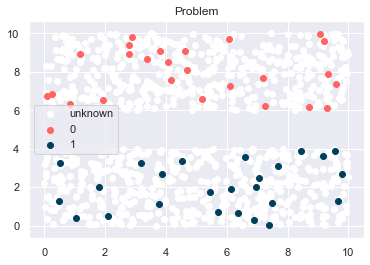

In [25]:
GL = GraphLaplacian(X0, Y0, X1)
GL.plot_problem()

iteration  162


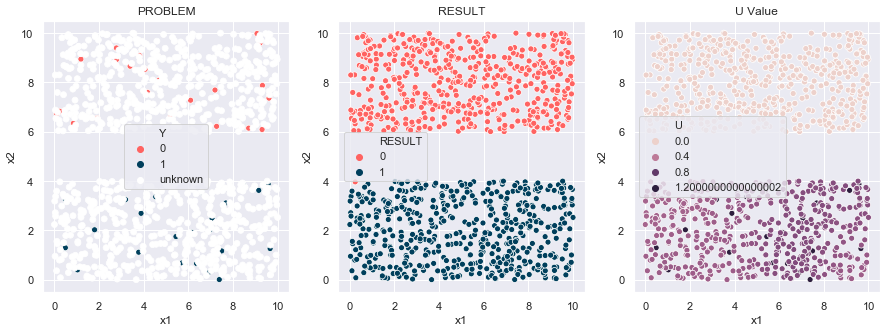

In [26]:
GL.solve()
GL.plot_result()

## Problem 2

In [18]:
N = 1000
L = 50

X0 = [[random.random()*10, random.random()*10] for i in range(np.int32(L))]
Y0 = [0 for i in range(np.int32(L/2))]
Y0 += [1 for i in range(np.int32(L/2))]
Y0 = np.array(Y0)

## Generate X Data
X1 = [[random.random()*10, random.random()*10] for i in range(N)]

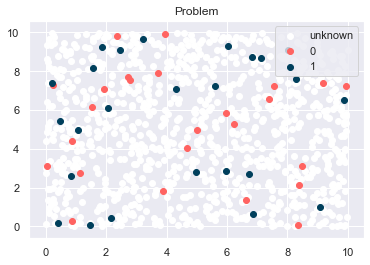

In [19]:
GL = GraphLaplacian(X0, Y0, X1)
GL.plot_problem()

In [20]:
GL.solve()

iteration  160


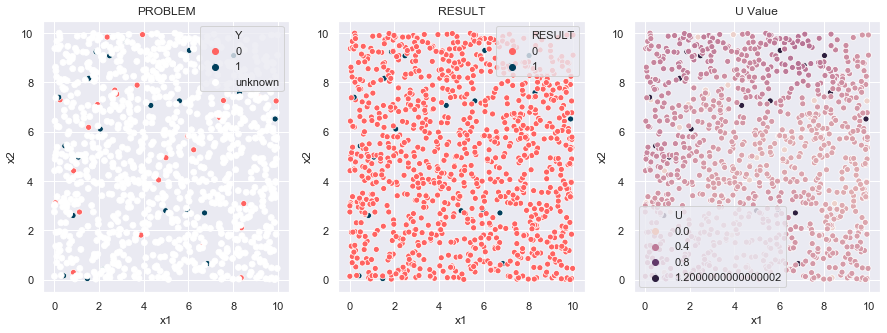

In [21]:
GL.plot_result()